In [ ]:
!pip install tensorflow==1.15.0
!pip install tensorflow-object-detection-api
#!pip install tensorflow-gpu==1.15
#!pip install tf_slim
#!pip install tf-models-official
#!pip install tensorflow-estimator==1.15.*

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [ ]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
model_dir = '/content/drive/MyDrive/MLiSP2/Object_Detection/Model'
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
!ls -ltra '{model_dir}'/..

total 75131
drwx------ 2 root root     4096 Apr 22 10:37 Test_imgs
drwx------ 2 root root     4096 Apr 25 10:48 Model
drwx------ 2 root root     4096 Apr 25 15:16 Model_2
-rw------- 1 root root 73665307 Apr 26 20:05 train.record
-rw------- 1 root root      474 Apr 26 20:05 labelmap.pbtxt
-rw------- 1 root root  2028100 Apr 26 20:05 test.record
-rw------- 1 root root     4070 Apr 28 18:22 pipeline.config
-rw------- 1 root root  1222849 May  3 10:35 Object_Detection.ipynb


In [ ]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/dctian/DeepPiCar'

# Number of training steps.
num_steps = 30000  # 200000
#num_steps = 100  # 200000

# Number of evaluation steps.
num_eval_steps = 50


# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

print('Pull it so that we have the latest code/data')
!git pull

/content
fatal: destination path 'DeepPiCar' already exists and is not an empty directory.
/content/DeepPiCar
Pull it so that we have the latest code/data
Already up to date.


In [ ]:
!ls

doc  driver  LICENSE  models  README.md


In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
^C
^C
[Errno 2] No such file or directory: '/content/models/research'
/content
object_detection/protos/*.proto: No such file or directory


KeyboardInterrupt: ignored

In [ ]:
%cd {repo_dir_path}/models/object_detection

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python code/xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python code/xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/DeepPiCar/models/object_detection
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0429 10:48:14.936444 140407930324864 module_wrapper.py:139] From code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0429 10:48:14.943957 140407930324864 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/DeepPiCar/models/object_detection/data/annotations/train.record


W0429 10:48:17.975683 140386053134208 module_wrapper.py:139] From code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0429 10:48:17.981145 140386053134208 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/object_detec

In [ ]:
test_record_fname = '/content/drive/MyDrive/MLiSP2/Object_Detection/test.record'
train_record_fname = '/content/drive/MyDrive/MLiSP2/Object_Detection/train.record'
label_map_pbtxt_fname = '/content/drive/MyDrive/MLiSP2/Object_Detection/labelmap.pbtxt'

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

[Errno 2] No such file or directory: '/content/models/research'
/content/DeepPiCar/models/object_detection


FileNotFoundError: ignored

In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 204M
drwx------  2 303230 5000 4.0K Jan  4  2019 .
drwxr-xr-x 23 root   root 4.0K Apr 28 18:22 ..
-rw-------  1 303230 5000  93M Jan  4  2019 model.ckpt.data-00000-of-00001
-rw-------  1 303230 5000  68K Jan  4  2019 model.ckpt.index
-rw-------  1 303230 5000  20M Jan  4  2019 model.ckpt.meta
-rw-------  1 303230 5000 4.3K Jan  4  2019 pipeline.config
-rw-------  1 303230 5000  24M Jan  4  2019 tflite_graph.pb
-rw-------  1 303230 5000  68M Jan  4  2019 tflite_graph.pbtxt


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

In [ ]:
import os
pipeline_fname = "/content/drive/MyDrive/MLiSP2/Object_Detection/pipeline.config"
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
import re

# training pipeline file defines:
# - pretrain model path
# - the train/test sets
# - ID to Label mapping and number of classes
# - training batch size
# - epochs to trains
# - learning rate
# - etc

# note we just need to use a sample one, and make edits to it.

num_classes = 6
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint: downloaded pre-trained model checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test, we created earlier with our training/test sets
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path: ID to label file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps (Number of epochs to train)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
%cd /content/drive/MyDrive/MLiSP2/Object_Detection/
!ls
!cat {label_map_pbtxt_fname}
#%cd /content/models/research

/content/drive/MyDrive/MLiSP2/Object_Detection
labelmap.pbtxt	Model_2			pipeline.config  test.record
Model		Object_Detection.ipynb	Test_imgs	 train.record
item {
    name: "box",
    id: 1,
    display_name: "box"
}
item {
    name: "left_turn",
    id: 2,
    display_name: "left_turn"
}
item {
    name: "person",
    id: 3,
    display_name: "person"
}
item {
    name: "right_turn",
    id: 4,
    display_name: "right_turn"
}
item {
    name: "traffic_light_down_green",
    id: 5,
    display_name: "traffic_light_down_green"
}
item {
    name: "traffic_light_up_red",
    id: 6,
    display_name: "traffic_light_up_red"
}


In [ ]:
!cat {pipeline_fname}

cat: {pipeline_fname}: No such file or directory


In [ ]:
!pip install lvis

In [ ]:
# TRAINING
num_steps = 30000
#SendEmail("Colab train started")
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir='{model_dir}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}
#SendEmail("Colab train finished")

In [ ]:
!ls -ltra '{model_dir}'

total 534255
-rw------- 1 root root 30108647 Apr 26 20:30 graph.pbtxt
drwx------ 2 root root     4096 Apr 26 20:41 eval_0
-rw------- 1 root root    68804 Apr 26 23:21 model.ckpt-24859.index
-rw------- 1 root root 75237296 Apr 26 23:21 model.ckpt-24859.data-00000-of-00001
-rw------- 1 root root 16341516 Apr 26 23:21 model.ckpt-24859.meta
-rw------- 1 root root    68804 Apr 26 23:31 model.ckpt-26308.index
-rw------- 1 root root 75237296 Apr 26 23:31 model.ckpt-26308.data-00000-of-00001
-rw------- 1 root root 16341516 Apr 26 23:31 model.ckpt-26308.meta
-rw------- 1 root root    68804 Apr 26 23:41 model.ckpt-27755.index
-rw------- 1 root root 75237296 Apr 26 23:41 model.ckpt-27755.data-00000-of-00001
-rw------- 1 root root 16341516 Apr 26 23:41 model.ckpt-27755.meta
-rw------- 1 root root    68804 Apr 26 23:51 model.ckpt-29207.index
-rw------- 1 root root 75237296 Apr 26 23:51 model.ckpt-29207.data-00000-of-00001
-rw------- 1 root root 16341516 Apr 26 23:51 model.ckpt-29207.meta
-rw-------

In [ ]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

In [ ]:
!echo creates the frozen inference graph in fine_tune_model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

In [ ]:
# https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193
# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

In [ ]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

In [ ]:
def region_of_interest(img, vertices):
    # Define a blank matrix that matches the image height/width.
    mask = np.zeros_like(img)
    # Retrieve the number of color channels of the image.
    channel_count = 3
    # Create a match color with the same color channel counts.
    match_mask_color = (255,) * channel_count
      
    # Fill inside the polygon
    cv.fillPoly(mask, vertices, match_mask_color)
    
    # Returning the image only where mask pixels match
    masked_image = cv.bitwise_and(img, mask)
    return masked_image
"""
def region_of_interest(img):
    height, width = img.shape[0], img.shape[1]
    mask = np.zeros_like(img)

    # only focus bottom half of the screen
    polygon = np.array([[
        (0, height * 2 / 3),
        (width, height * 2 / 3),
        (width, height),
        (0, height),
    ]], np.int32)

    cv.fillPoly(mask, polygon, 255)
    cropped_edges = cv.bitwise_and(img, mask)
    return cropped_edges
"""

def get_line_values(img):
  region_of_interest_vertices = [
      (0, img.shape[0]),
      (img.shape[1] / 2, img.shape[0] / 2),
      (img.shape[1], img.shape[0]),
  ]

  gray_image = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  # Call Canny Edge Detection here.
  cannyed_image = cv.Canny(gray_image, 100, 200)

  #cropped_image = region_of_interest(
  #    cannyed_image)

  cropped_image = region_of_interest(
    cannyed_image,
    np.array(
        [region_of_interest_vertices],
        np.int32
     ),
  )
  lines = cv.HoughLinesP(
      cropped_image,
      rho=6,#6
      theta=np.pi / 30,#30
      threshold=30, #40
      lines=np.array([]),
      minLineLength=40, #15
      maxLineGap=5 #5
  )
  if lines is None:
    return [[0, 0, 0, 0]]
  lines_list = []
  for i in lines:
    for ii in i:
        x1, y1, x2, y2  = ii
        lines_list.append([x1, y1, x2, y2 ])

  return lines_list

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
  # If there are no lines to draw, exit.
  if lines is None:
      return
  # Make a copy of the original image.
  img = np.copy(img)
  # Create a blank image that matches the original in size.
  line_img = np.zeros(
      (
          img.shape[0],
          img.shape[1],
          3
      ),
      dtype=np.uint8,
  )
  # Loop over all lines and draw them on the blank image.
  for i in lines:
          x1, y1, x2, y2  = i
          cv.line(line_img, (x1, y1), (x2, y2), color, thickness)
          
  # Merge the image with the lines onto the original.
  img = cv.addWeighted(img, 0.8, line_img, 1.0, 0.0)
  # Return the modified image.
  return img


In [ ]:

lines = np.asarray(get_line_values(test_images[449]))
print(lines)
line_image = draw_lines(test_images[449], lines)
plt.imshow(line_image)
"""
avg_lines = []
for i in range(lines.shape[1]):
  sum = 0
  for ii in range(lines.shape[0]):
    sum +=  lines[ii][i]
  avg_lines.append(sum / lines.shape[0])
"""

x1, y1, x2, y2 = np.median(lines[:,0]),np.median(lines[:,1]),np.median(lines[:,2]),np.median(lines[:,3])
print(x1, y1, x2, y2)

In [ ]:
"""
turn_threshold = 40 #40...
def get_turn_value(turn_list ,direction):
    print("Using Object Detection for angle detection")
    if (turn_list[0][0] - turn_list[0][1]) >= turn_threshold and (turn_list[0][0] - turn_list[0][1]) < turn_threshold+10: 
      angle_value = 0.4 
    elif (turn_list[0][0] - turn_list[0][1]) >= turn_threshold+10 and (turn_list[0][0] - turn_list[0][1]) < turn_threshold+20: 
      angle_value = 0.3  
    elif (turn_list[0][0] - turn_list[0][1]) >= turn_threshold+20 and (turn_list[0][0] - turn_list[0][1]) < turn_threshold+30: 
      angle_value = 0.2  
    elif (turn_list[0][0] - turn_list[0][1]) >= turn_threshold+30 and (turn_list[0][0] - turn_list[0][1]) < turn_threshold+40: 
      angle_value = 0.1 
    elif (turn_list[0][0] - turn_list[0][1]) >= turn_threshold+40:  
       angle_value = 0
    else:
      angle_value = 0.5

    if direction == "right":
      return 1 - angle_value
    else:
      return angle_value
"""

In [5]:
!pip install tensorflow==1.15.0
!pip install tensorflow-object-detection-api
#!pip install tensorflow-gpu==1.15
#!pip install tf_slim
#!pip install tf-models-official
#!pip install tensorflow-estimator==1.15.*

     |████████████████████████████████| 412.3MB 28kB/s 
     |████████████████████████████████| 3.8MB 29.3MB/s 
     |████████████████████████████████| 512kB 50.0MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=df598b731bf336f74a0f35238a4fc2ae5af0c614ed8c076b360d458248248f99
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

     |████████████████████████████████| 583kB 5.0MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 3.2MB 10.1MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-cp37-none-any.whl size=844515 sha256=af040e13b4888d0ebd493d0dc6b9d98b3e06bd8b49f5df7d7a53d617610bdf3a
  Stored in directory: /root/.cache/pip/wheels/4a/54/d0/cfca11930c4b2025d40dede77059094070a67cc3e7bd3b285f
Successfully built tensorflow-object-detection-api


In [2]:
#%reset
#%matplotlib inline
import cv2 as cv
import numpy as np
from shapely.geometry import Polygon
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from tensorflow.keras.models import load_model
import shapely.geometry 
import descartes


ModuleNotFoundError: ignored

In [ ]:
print(tf.__version__)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
test_images = np.asarray(np.load("/content/drive/MyDrive/MLiSP2/Holdout_Channels/Holdout_RGB_Not_Resized.pkl",allow_pickle=True))
print(test_images.shape)

In [ ]:
num_classes = 6
model_dir = '/content/drive/MyDrive/MLiSP2/Object_Detection/Model'
output_directory = '%s/fine_tuned_model' % model_dir
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb") 

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(pb_fname, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map_pbtxt_fname = '/content/drive/MyDrive/MLiSP2/Object_Detection/labelmap.pbtxt'
label_map = label_map_util.load_labelmap(label_map_pbtxt_fname)
categories = label_map_util.convert_label_map_to_categories(
label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [3]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict



In [4]:
#!pip install keras==2.3.0
%cd /content/drive/MyDrive/MLiSP2/
model = load_model("Angle_Model.h5")
#temp_X_test = np.load("X_test_temp.npy")[:200]
#temp_y_test = np.load("y_test_temp.npy")[:200]

#temp = []
#for i in temp_X_test:
#  img = cv.resize(i, (320, 240))
#  temp.append(img)
#temp_X_test = np.asarray(temp)
#print(temp_X_test.shape)
#print(temp_y_test.shape)

[Errno 2] No such file or directory: '/content/drive/MyDrive/MLiSP2/'
/content


NameError: ignored

In [ ]:
def placehold(coordinates, object_detect):
  xmax, xmin, ymax, ymin = object_detect
  detaction_box = Polygon([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
  region_of_interest = Polygon([[coordinates[0], coordinates[1] ], [coordinates[2], coordinates[3]], [coordinates[4], coordinates[5]]])
  find_intersection = detaction_box.intersection(region_of_interest)
  overlap = find_intersection.area
  return overlap, find_intersection

In [ ]:
def turn(turn_cord, direction, multiplier=0.008):
  ymax, ymin = turn_cord[0]
  difference = ymax - ymin

  if direction == "left":
    angle = 0.5 - (difference * multiplier)
    angle_amount = max(0, angle)

  elif direction == "right":
    angle = 0.5 + (difference * multiplier)
    angle_amount = min(1, angle)

  return abs(angle_amount)

In [ ]:
def a_turn_f(turn_amount):

  if turn_amount > 0.66 and turn_amount < 0.78: #right
    #number = turn_amount - 0.5
    x1 = 140  #Where x1 is the bottom left x value in the triangle
    y1 = 240

    x2 = 320  #Where x2 is the middle x value in the triangle
    y2 = 80 # 120

    x3 = 320
    y3 = 240
  elif turn_amount >= 0.78:
    x1 = 120  #Where x1 is the bottom left x value in the triangle
    y1 = 240

    x2 = 320  #Where x2 is the middle x value in the triangle
    y2 = 180 # 120

    x3 = 320
    y3 = 240

  elif turn_amount <= 0.34: #left
    x1 = 0  #Where x1 is the bottom left x value in the triangle
    y1 = 240

    x2 = 0  #Where x2 is the middle x value in the triangle
    y2 = 120 # 120

    x3 = 160
    y3 = 240
  
  else:
    x1 = 0
    y1 = 240

    x2 = 160
    y2 = 60

    x3 = 320
    y3 = 240

  return [x1, y1, x2, y2, x3, y3]

In [ ]:
def predict_angle(model):
      img = cv.resize(test_images[n], (80, 60))  
      img_expanded = np.expand_dims(img, axis=0) 
      img_expanded = img_expanded / 255. 
      pred = model.predict(img_expanded)[0][0]
      return pred 
      


In [1]:
%matplotlib inline
box_loc, person_loc, traffic_light_up_red_loc, speed, angle, left_turn_loc, right_turn_loc = [], [], [], [], [], [], []
classes = ["box",
           "left_turn", 
           "person", 
           "right_turn",
           "traffic_light_down_green",
           "traffic_light_up_red"]

object_threshold = 0.5
person_threshold = [76, 64] # [76, 64]
box_threshold = 60 #60
traffic_light_red_threshold = 60  #60

for i in range(test_images.shape[0]):
    # person --> 137 449 511 722 821 325
    # box --> 632 630 634 700 911 976
    # 260
    n = 149

    # Actual detection.
    output_dict = run_inference_for_single_image(test_images[n], detection_graph)

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        test_images[n],
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        min_score_thresh=object_threshold,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)

    #print(output_dict['detection_boxes'][:5])
    #print([i for i in output_dict['detection_scores'] if i > object_threshold])
    #for v in range(len(output_dict['detection_scores'])):
    #  if output_dict['detection_scores'][v] > object_threshold:
    #   print(classes[output_dict['detection_classes'][v]-1])

    for ii in range(len(output_dict['detection_scores'])):
      if output_dict['detection_scores'][ii] >= object_threshold:

        idx = output_dict['detection_classes'][ii] - 1
        current_class = classes[idx]
        ymin, xmin, ymax, xmax = output_dict['detection_boxes'][ii]
        width, height = 320, 240
        ymin, xmin, ymax, xmax = ymin * height, xmin * width, ymax * height, xmax * width
        if current_class == "person":
          person_loc.append([xmax, xmin, ymax, ymin])
        elif current_class == "box":
          box_loc.append([xmax, xmin, ymax, ymin])
        elif current_class == "traffic_light_up_red":
          traffic_light_up_red_loc.append([ymax, ymin])
        elif current_class == "left_turn":
          left_turn_loc.append([ymax, ymin])
        elif current_class == "right_turn":
          right_turn_loc.append([ymax, ymin])


        if left_turn_loc and len(angle) != (i + 1):
          angle.append(turn(left_turn_loc, direction = "left"))
        elif right_turn_loc and len(angle) != (i + 1):
          angle.append(turn(right_turn_loc, direction = "right"))
          
        if person_loc:
            if (person_loc[-1][0] - person_loc[-1][1] > person_threshold[0]) or (person_loc[-1][2] - person_loc[-1][3] > person_threshold[1]):
              #area_triangle = 9600*(2*angle[0] + 1)*(1 - angle[-1])
              #threshold_for_triangle = area_triangle * 300 / 9600
              if len(angle) != (i + 1):
                angle.append(predict_angle(model))

              coordinates = a_turn_f(0.5)
              #print(person_loc[iii])
              area, _ = placehold(coordinates, person_loc[-1])

              #print(f"Area of trig: {area_triangle} | Threshold of trig: {threshold_for_triangle}")
              #print(f"Overlap Area: {area}")

              if area > 0 and len(speed) != (i + 1):
                speed.append(0)
                
      
        if box_loc and len(speed) != (i + 1):
          #print(f"xmin: {box_loc[-1][1]}\nxmax: {box_loc[-1][0]}\nymin: {box_loc[-1][-1]}\nymax: {box_loc[-1[2]}")
          if (box_loc[-1][2] - box_loc[-1][3] > box_threshold):
            if len(angle) != (i + 1):
              angle.append(predict_angle(model))
              
            #area_triangle = 9600*(2*angle[-1] + 1)*(1 - angle[-1])
            #threshold_for_triangle = area_triangle * 300 / 9600
            coordinates = a_turn_f(angle[-1])
            #print(box_loc[-1])
            area, _ = placehold(coordinates, box_loc[-1])
            #print(f"area of trig: {area_triangle} | threshold of trig: {threshold_for_triangle}")
            #print(f"Overlap Area: {area}")
            if area > 0 and len(speed) != (i + 1):
              speed.append(0)
              

        if traffic_light_up_red_loc and len(speed) != (i + 1):
          if (traffic_light_up_red_loc[0][0] - traffic_light_up_red_loc[0][1]  > traffic_light_red_threshold):
              speed.append(0)
              
      



      traffic_light_up_red_loc.clear()
      box_loc.clear()
      person_loc.clear()
      left_turn_loc.clear()
      traffic_light_up_red_loc.clear()
      right_turn_loc.clear()

    if len(angle) != (i + 1):
      angle.append(predict_angle(model))
    if len(speed) != (i + 1):
        speed.append(1)

    print(f"Speed: {speed} \nAngle: {angle}")
    #print(f"Speed Size: {len(speed)} \nAngle Size: {len(angle)}")
    #print(coordinates)
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    ax.plot([0, 160, 320, 0], [239, 60, 239, 239], color="red", linewidth=3)
    #ax.plot([coordinates[0], coordinates[2], coordinates[4], coordinates[0]], [coordinates[1]-1, coordinates[3], coordinates[5]-1, coordinates[5]-1], color="red", linewidth=3)
    ax.add_patch(descartes.PolygonPatch(_, fc='b', ec='k', alpha=0.2))
    #seg = draw_lines(test_images[n], get_line_values(test_images[n]))
    #ax.plot([0,160],[240, 120], color="blue", linewidth=5)
    #ax.plot([160,320],[120, 240], color="blue", linewidth=5)
    #ax.imshow(seg)
    ax.imshow(test_images[n])
    raise
    #if len(speed) == (i + 1) and len(angle) == (i+1):
      #break


 


        #if i % 100 == 0:
          #print(f"Progress: {round((i + 1) / test_images.shape[0], 2)}%")


NameError: ignored

In [ ]:
%cd /content/drive/MyDrive/MLiSP2
speed_array = np.asarray(speed, dtype=int).reshape(-1, 1)
angle_array = np.asarray(angle, dtype=float).reshape(-1, 1)

print(speed_array)
print(angle_array)



/content/drive/MyDrive/MLiSP2
[[0]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[[0.5622493 ]
 [0.79927427]
 [0.32867193]
 ...
 [0.46162957]
 [0.        ]
 [0.24400452]]


In [ ]:
angle_array.shape

(1020, 1)

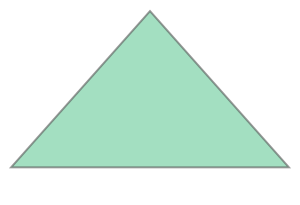

In [ ]:
Polygon([[coordinates[0], 240-coordinates[1] ], [coordinates[2], 240-coordinates[3]], [coordinates[4], 240-coordinates[5]]])
#[[0, 0], [228.27447891235352, 68.79414081573486], [388.2744789123535, 0]]

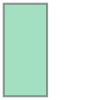

In [ ]:
Polygon([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])

In [ ]:
import pandas as pd

columns = ["image_id", "angle", "speed"]

image_id = np.asarray(range(1, test_images.shape[0] + 1)).reshape(-1, 1).astype(int)

concat_columns = np.concatenate((image_id, angle_array, speed_array), axis=1)
results = pd.DataFrame(concat_columns, columns=columns)

results["image_id"] = results["image_id"].astype(int)
results["speed"] = results["speed"].astype(int)
print(results)



      image_id     angle  speed
0            1  0.562249      0
1            2  0.799274      1
2            3  0.328672      1
3            4  0.255977      1
4            5  0.075842      1
...        ...       ...    ...
1015      1016  0.497246      1
1016      1017  0.666625      0
1017      1018  0.461630      1
1018      1019  0.000000      1
1019      1020  0.244005      1

[1020 rows x 3 columns]


In [ ]:
results["speed"].value_counts()


1    564
0    456
Name: speed, dtype: int64

In [ ]:
results.to_csv("/content/drive/MyDrive/MLiSP2/holdout_submission.csv", header=True, index=False)

/bin/bash: line 0: cd: /MyDrive: No such file or directory


In [ ]:
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

# CONVERTING frozen graph to quantized TF Lite file...
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

python3: can't open file '/content/models/research/object_detection/export_inference_graph.py': [Errno 2] No such file or directory
python3: can't open file '/content/models/research/object_detection/export_tflite_ssd_graph.py': [Errno 2] No such file or directory
2021-05-07 22:30:51.284043: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-05-07 22:30:51.295520: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-07 22:30:51.295590: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a9530f3e1da4): /proc/driver/nvidia/version does not exist
2021-05-07 22:30:51.296120: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-05-07 22:30:51.303868: I tensorflow/core/platform/

In [ ]:
# download this file from google drive.
#%cd /content/gdrive/MyDrive/MLiSP2/Object_Detection/Model_2/fine_tuned_model/

!ls -lt '/content/drive/MyDrive/MLiSP2/Object_Detection/Model/fine_tuned_model/road_signs_quantized.tflite'

-rw------- 1 root root 4793304 May  7 22:15 /content/drive/MyDrive/MLiSP2/Object_Detection/Model/fine_tuned_model/road_signs_quantized.tflite
